## Final project. Applied Mathematics / Numerical Analysis / P1.4

Using Lagrangian finite elements with Chebyshev nodes, defined on square, of arbitrary order

Find the solution of 

$$
-\Delta \mathbf u + \mathbf u = \mathbf f \text{ in } \Omega, \qquad n \cdot \delta u = 0 \text{ on } \partial \Omega
$$

on the square $\Omega = [0,1]^2$. For the sake of simplicity you can consider just **one finite element** and homogeneous Neumann boundary conditions. 

The above problem can be rewritten in matrix form as

$$
A u = (K+M) u =  b
$$

where $K$ is the stiffness matrix, and $M$ is the mass matrix.

In order to do so, express $u$ as a linear combination of basis functions, multiply from the left with a basis function, and integrate by parts the laplacian to obtain:

$$
K_{ij} := \int_\Omega \nabla v_i \cdot \nabla v_j = \int_\Omega \nabla l_{ij} \cdot \nabla l_{kl}, \qquad M_{ij} = \int_\Omega v_i v_j, \qquad b_i = \int_\Omega v_i f
$$

In [1]:
%pylab inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
matplotlib.rcParams['figure.figsize'] = np.array(matplotlib.rcParams['figure.figsize']) * 2.5

import sympy as sym
from mpl_toolkits.mplot3d import Axes3D

Populating the interactive namespace from numpy and matplotlib


### 1 Construct (or use the available functions from numpy/scipy) the chebishev nodes of given order

Once you constructed them, plot them.

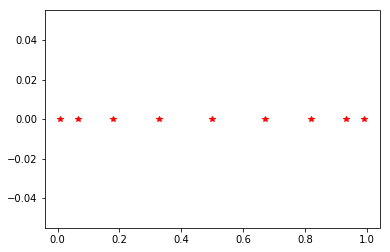

In [2]:
order = 9
a, b = 0, 1

x_sym, y_sym = sym.var('x'), sym.var('y')
u_sym = sym.cos(sym.pi * x_sym) * sym.cos(3 * sym.pi * y_sym)

# Call C the chebishev nodes between 0 and 1
def cheby_constr(order, a, b):
    C = np.array([np.cos((2.*j-1)/(2.*order)*np.pi) for j in range(1,order+1)])
    return 0.5 * (a + b) - 0.5 * (b - a) * C

q = C = cheby_nodes = cheby_constr(order, a, b)

_ = plot(C, 0*C, "r*")

### 2 Construct (or use the available functions from numpy/scipy) the 1D Lagrange basis functions on the Chebishev nodes
Make sure each entry of `basis_1d` is a callable function, that you can evaluate at a given point. Plot all of the basis functions, using a numpy array `Vs`, storing all basis functions evaluated on evenly spaced points, called `s`

(257, 9)

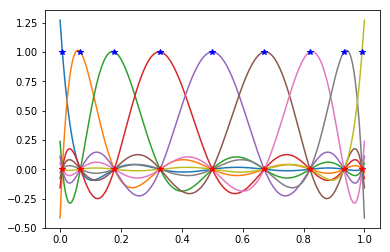

In [3]:
plot_resolution = 257
plot_linspace = np.linspace(a, b, 257)

def lagrange_bases_cheby(cheby_nodes, order, plot_resolution, plot_linspace):
    basis_1d = [] 

    Vs = zeros((plot_resolution, order))

    x = sym.symbols('x')

    for j in range(order):
        l_partial = 1 + 0. * x  # Force it to be a sympy expression
        for i in range(order):
            if i != j:
                # Create the basis functions by multiplying all the previous
                # elements in `l_partial`; this creates a basis function
                # (callable) for the order `j`.
                l_partial *= (x - cheby_nodes[i])/(cheby_nodes[j] - cheby_nodes[i])

        basis_1d.append(l_partial)

    for col in range(order):
        Vs[:, col] = sym.lambdify(x, basis_1d[col])(plot_linspace)

    return basis_1d, Vs

basis_1d, Vs = lagrange_bases_cheby(C, order, plot_resolution, plot_linspace)
        
_ = plot(plot_linspace, Vs)
_ = plot(q, zeros(q.shape[0]), "r*")
_ = plot(q, ones(q.shape[0]), "b*")

Vs.shape

### 3 Construct three one-dimensional quadrature formulas, to integrate the matrices, the right hand side, and the error

In general the size of the quadratures should be selectable by the user.

Anything that should be evaluated on one of quadrature points, should be named accordingly (i.e., using a suffix `m,r,e`) for the three collections

In [4]:
# We use three different coefficients: the first is to calculate the quadrature of the matrices `K` and `M`,
# the second is for the vector of `b` coefficients, while the third is used to calculate the overall
# approximation error at the end.
quadrature_size_matrices = 10
quadrature_size_rhs      = 11
quadrature_size_error    = 12

# Gaussian quadrature is used to perform a definite integral approximation of a function using summation.
# If the function is a polynomial, the approximation is perfect.
# The points where to compute the approximation can be calculated analytically, and the weights to apply
# to the points are the roots of the Legendre polynomials.

# Using `np.polynomial.legendre.leggauss`, we can obtain the points Q and the weights W to apply to a
# polynomial of a desired order: we then need to scale them to our interval (a, b), since they are by
# default returned for an interval (-1, 1).

def gauss_legendre_quadr(poly_order, a, b):
    Q, W = np.polynomial.legendre.leggauss(poly_order)
    return 0.5 * (Q + 1) * (b - a) + a, 0.5 * (b - a) * W

Qm, Wm = gauss_legendre_quadr(quadrature_size_matrices, a, b)  
Qr, Wr = gauss_legendre_quadr(quadrature_size_rhs,      a, b)       
Qe, We = gauss_legendre_quadr(quadrature_size_error,    a, b)     

# # To test the functioning, we compute the approximation of the integral of x**2 in the interval (a, b)
# # using summation and then correcting with the weights. This should result in 1/3.
# integral_of_x_squared = np.sum(Qm*Qm * Wm)
# assert(abs(integral_of_x_squared - 1./3) < 1e-10)
# integral_of_x_squared

### 4 Evaluate all the one dimensional basis functions at each collection of quadrature points

Store the results in three different numpy arrays, one for quadrature. Use suffix `m,r,e` for the arrays representing the basis functions evaluated at the quadrature points to be used for the matrices, rhs, and errors respectively.

In [5]:
def basis_evaluation_at_quad(order, basis_1d,
                             n_quad_m, n_quad_r, n_quad_e,
                             points_m, points_r, points_e):
    
    Vm = zeros((n_quad_m, order))
    Vr = zeros((n_quad_r, order))
    Ve = zeros((n_quad_e, order))
    x = sym.symbols('x')

    for col in range(order):
        basis_func = sym.lambdify(x, basis_1d[col])
        Vm[:, col] = basis_func(points_m)
        Vr[:, col] = basis_func(points_r)
        Ve[:, col] = basis_func(points_e)
        
    return Vm, Vr, Ve

Vm, Vr, Ve = basis_evaluation_at_quad(order, basis_1d,
                                      quadrature_size_matrices,
                                      quadrature_size_rhs,
                                      quadrature_size_error,
                                      Qm, Qr, Qe)

### 5 Evaluate the derivatives of the basis functions at each collection of quadrature points

Store the results in three different numpy arrays, one for quadrature. Use suffix `m,r,e` for the arrays representing the basis functions evaluated at the quadrature points to be used for the matrices, rhs, and errors respectively.

In [6]:
# We need to calculate the derivatives of the Lagrange basis because
# they are needed to compute the matrix K.
# We calculate them only once because the function to approximate is
# the same in both dimensions.
def basis_derivatives_at_quad(order, basis_1d,
                             n_quad_m, n_quad_r, n_quad_e,
                             points_m, points_r, points_e):
    Dm = zeros((n_quad_m, order))
    Dr = zeros((n_quad_r, order))
    De = zeros((n_quad_e, order))
    x = sym.symbols('x')

    for col in range(order):
        first_deriv = sym.lambdify(x, basis_1d[col].diff(x, 1))
        Dm[:, col] = first_deriv(points_m)
        Dr[:, col] = first_deriv(points_r)
        De[:, col] = first_deriv(points_e)
        
    return Dm, Dr, De

Dm, Dr, De = basis_derivatives_at_quad(order, basis_1d,
                                       quadrature_size_matrices,
                                       quadrature_size_rhs,
                                       quadrature_size_error,
                                       Qm, Qr, Qe)

### 6 Construct the 2D quadrature formulas as tensor products of the 1D ones

Given two one dimensional quadrature formulas with points $x_r$ and $y_q$, we can construct the corresponding two dimensional quadrature formulas by using `einsum` to obtain the weights of higher dimensional tensor product quadrature formulas, on the points $(x_r, y_q)$:

$$
X_{qr} = (x_r, y_q), \quad J2_{qr} = w_r w_q
$$

Use lexycographical ordering w.r.t. to C: `x` runs faster than `y`.

Integration of a scalar function of two variables on the square can then be approximated as

$$
\int_0^1 \int_0^1 f(x,y) dx \, dy \sim \sum_{r=0}^{n_q-1}\sum_{q=0}^{n_q-1} f(x_r, y_q)  w_r w_q = \sum_{r=0}^{n_q-1}\sum_{q=0}^{n_q-1} f(X_{qr})  J_{qr}
$$


In [7]:
# `einsum` performs multiplications of vectors/matrices/tensors, using indices on the left to iterate
# over the given ndarrays, and calculating the rhs using multiplication between the indices.
# To test a simple square operation:
#print(einsum("i,j -> ij", np.arange(4), np.arange(4)))

def weights_2d(Wm, Wr, We):
    op = 'q, r -> qr'
    W2m = einsum(op, Wm, Wm)
    W2r = einsum(op, Wr, Wr)
    W2e = einsum(op, We, We)
    return W2m, W2r, W2e

W2m, W2r, W2e = weights_2d(Wm, Wr, We)

### 7 Construct the 2D basis functions as tensor products of the 1D ones

Given a set of one dimensional basis functions, one can construct the tensor product space for two dimensional problems by defining

$$
V_{ij}(x,y) := v_i(y) v_j(x), \quad i,j = 0,\ldots,n-1.
$$

If we only need these to be evaluated at some quadrature points, $V_{iq} = v_i(x_q)$, we can construct the corresponding two dimensional basis functions by using `einsum` to obtain higher dimensional arrays on tensor product points:

$$
V2_{qr\, ij} =  v_i(y_q) v_j(x_r)
$$

representing one two dimensional basis function (identified by the two indices $i,j$, one indicating the $j$-th basis function along $x$, and the other identifying the $i$-th basis function along $y$), evaluated at the point $(x_r, y_q)$.

Notice that we use lexycographical ordering: `x` runs faster than `y`, both for the numbering of the basis functions and for the order of the quadrature points. Moreover, we group together the indices running over the quadrature points, and the ones running over the basis function indices, while maintaining the lexycographical ordering.

This allows you to resize the arrays, so that the results only have two dimensional matrices, with shape `(quadrature_size_xxx^2,order^2)`. 

In [8]:
def basis_functions_2d(Vs, Vm, Vr, Ve, Dm):
    operation = 'qi, rj -> qrij'

    V2s = einsum(operation, Vs, Vs)

    V2m = einsum(operation, Vm, Vm)
    V2r = einsum(operation, Vr, Vr)
    V2e = einsum(operation, Ve, Ve)

    VDm = einsum(operation, Vm, Dm)
    DVm = einsum(operation, Dm, Vm)
    return V2s, V2m, V2r, V2e, VDm, DVm

V2s, V2m, V2r, V2e, VDm, DVm = basis_functions_2d(Vs, Vm, Vr, Ve, Dm)

order
plot_resolution
Vs.shape
V2s.shape

9

257

(257, 9)

(257, 257, 9, 9)

Notice that, since you used the correct ordering, you can actually plot some of the basis functions, for example the 2 along x, 3 along y, as:

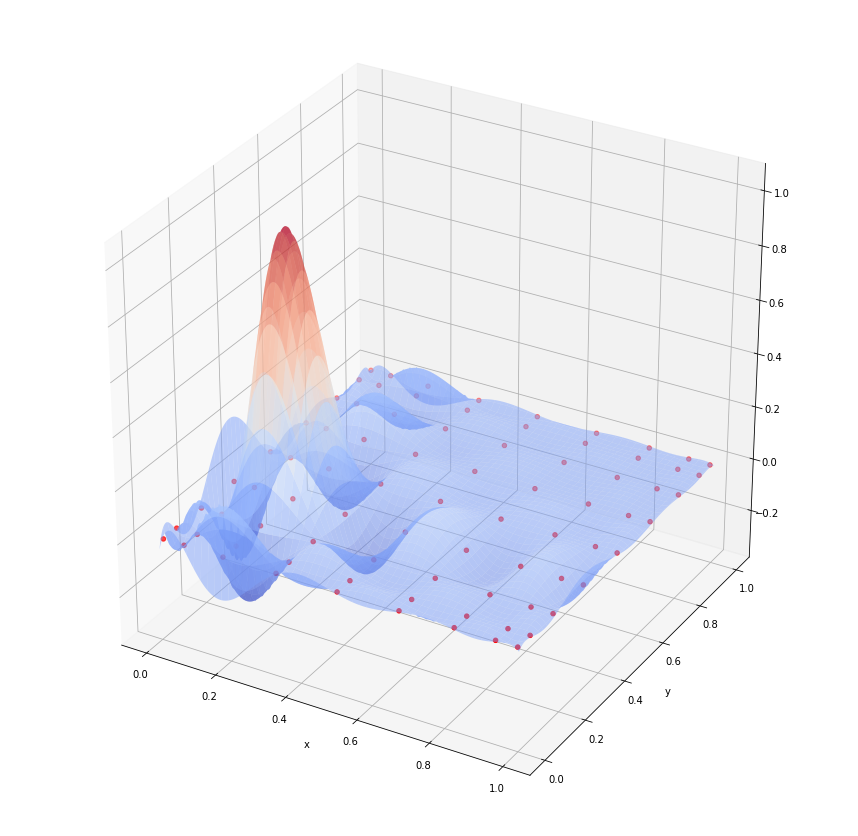

In [9]:
X = meshgrid(plot_linspace, plot_linspace)
Q = meshgrid(cheby_nodes, cheby_nodes)

fig = figure(figsize=[15,15])
ax = fig.gca(projection='3d')
_ = ax.set_xlabel("x")
_ = ax.set_ylabel("y")
# surf2 = ax.plot_surface(X[0], X[1], V2s[:,:,order//2,order//2], rstride=5, cstride=5, cmap=cm.coolwarm, alpha=0.5)
surf2 = ax.plot_surface(X[0], X[1], V2s[:,:,3,2], rstride=5, cstride=5, cmap=cm.coolwarm, alpha=0.5)
scatter = ax.scatter(Q[0], Q[1], zeros_like(Q[0]), c='r', marker='o')

### 8 Assemble the matrices and the right hand side

Using `einsum`, assemble the arrays representing the matrices and then resize them to be two-dimensional. Careful on how the stiffness matrix is defined:

$$
K_{ij \, kl} = \int_{\Omega} \nabla v_{ij} \cdot \nabla v_{kl} = \sum_q \sum_r (v'_j(x_r)v_i(y_q) v'_l(x_r)v_k(y_q) +v_j(x_r)v'_i(y_q) v_l(x_r)v'_k(y_q) )w_r w_q
$$

Using summation convention, this is equivalent to:

```
(Vm[i][q]*Dm[j][r] Vm[k][q]*Dm[l][r] + Dm[i][q]*Vm[j][r] *Dm[k][q]Vm[l][r]) W[r]*W[q]
```
or
```
(VDm[q][r][i][j]^2 + DVm[q][r][i][j]^2) W2[q,r]
```
<!--(the square -->

In [10]:
def matrix_2d_builder(order, V2m, W2m, VDm, DVm):
    # M = einsum('qrij, qrkl, q, r', V2m, V2m, Wm, Wm)
    M = einsum('qrij, qrkl, qr', V2m, V2m, W2m).reshape((order**2, order**2))

    _op = "qrij, qrkl -> qrikjl"
    K_part1 = einsum(_op, VDm, VDm)
    K_part2 = einsum(_op, DVm, DVm)

    K = einsum("qrikjl, qr", (K_part1 + K_part2), W2m)
    K = K.reshape((order**2, order**2))

    A = K+M
    return A

A = matrix_2d_builder(order, V2m, W2m, VDm, DVm)
print("order^2 = {}^2 = {}".format(order, order**2))
print("A.shape =", A.shape)

order^2 = 9^2 = 81
A.shape = (81, 81)


### 9 Using a known solution, construct a right hand side that would produce the given solution, and assemble it

Given a solution that satisfies the boundary conditions (for example:) 

$$
u(x,y) = \cos(\pi x)\cos(3\pi y)
$$
compute its laplacian, put a minus in front of it, and sum $u$ to it. The result is the forcing term $f$ that you have to use in order to obtain $u$ as a solution to the problem. Call it `my_function`, compute the right hand side by integrating with the basis functions and reshape it to be a vector of size `order^2`.

The 2D laplacian of a function $g$ is: $$\Delta g = \frac{\partial g}{\partial x^2} + \frac{\partial g}{\partial y^2}$$

In [11]:
def my_function(x, y, u):
    f = sym.lambdify((x_sym, y_sym), (- (u.diff(x_sym, 2) + u.diff(y_sym, 2)) + u))

    F = zeros((len(x), len(y)))
    for i_id, i in enumerate(x):
        for j_id, j in enumerate(y):
            F[i_id, j_id] = f(i, j)
            
    return F

def rhs_2d_builder(order, Qr, u_sym_func, V2r, W2r):
    Fr = my_function(Qr, Qr, u_sym_func)
    b_coeff = einsum('qrij, qr, qr', V2r, Fr, W2r).reshape((order**2))
    return b_coeff

b_coeff = rhs_2d_builder(order, Qr, u_sym, V2r, W2r)
b_coeff.shape

(81,)

### 10 Solve the linear system, and plot the solution

Use a direct solver to solve the linear system. Once you have the coefficients `u` as a vector, reshape it to a matrix, and use einsum to have its values on the `plot_linspace` linear space.

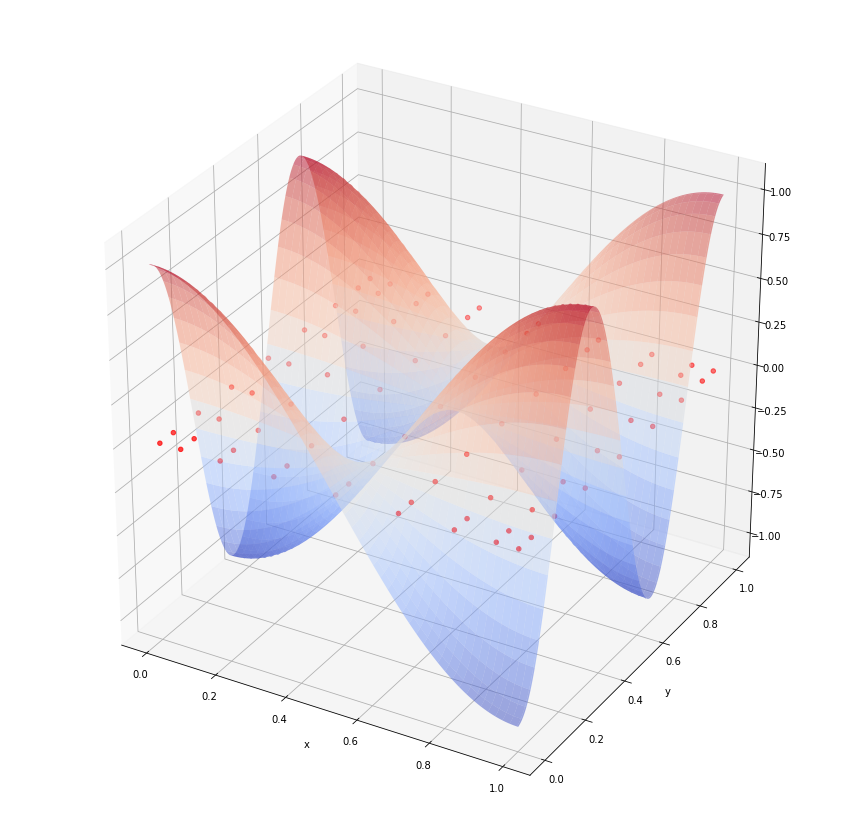

In [12]:
def solve_system(order, A, b_coeff, V2s):
    u = solve(A, b_coeff).reshape((order, order))
    return u, einsum('qrij, ij', V2s, u)

def plot_3d_solution(plot_linspace, cheby_nodes, u_grid):
    X = meshgrid(plot_linspace, plot_linspace)
    Q = meshgrid(cheby_nodes, cheby_nodes)
    fig = figure(figsize=[15, 15])
    ax = fig.gca(projection='3d')
    _ = ax.set_xlabel("x")
    _ = ax.set_ylabel("y")
    surf2 = ax.plot_surface(X[1], X[0], u_grid, rstride=5, cstride=5, cmap=cm.coolwarm, alpha=0.5)
    # scatter = ax.scatter(Q[1], Q[0], u(Q[0],Q[1]), c='r', marker='o')
    scatter = ax.scatter(Q[1], Q[0], zeros_like(Q[0]), c='r', marker='o')
    
u_approx, u_grid = solve_system(order, A, b_coeff, V2s)
plot_3d_solution(plot_linspace, cheby_nodes, u_grid)

### 11 Compute the L2 error of the solution

The L2 error is defined as 

$$
\| u - u_h \| := \sqrt{\int_\Omega (u(x,y) - u^{ij} V_{ij}(x,y))^2 dx\, dy } \sim \sqrt{\sum_q \sum_r (u(x_r, y_q) -V_{qrij} u^{ij})^2 W_{qr}}
$$

use the quadrature formula and the matrix you constructed above to compute the approximate solutions at the quadrature points.

In [13]:
def apply_solution(x, y):
    f = lambda x, y: np.cos(np.pi * x) * np.cos(3 * np.pi * y)
    grid = np.zeros((x.shape[0], y.shape[0]))
    for i_id, i in enumerate(x):
        for j_id, j in enumerate(y):
            grid[i_id, j_id] = f(i, j)
    return grid
    
u_precise = apply_solution(Qe, Qe)

def calc_l2_norm(u_real, u_approx, V2e, W2e):
    norm = np.sqrt( np.einsum('qr, qr', (u_real - np.einsum('qrij, ij', V2e, u_approx))**2, W2e))
    return norm

norm = calc_l2_norm(u_precise, u_approx, V2e, W2e)
norm

0.004544573486067266

### 12 Group together all of the above in a function

The function should take as input the `degree` of the one dimensional basis space, the degrees of the three quadrature formulas, a number of points where you want to produce the outputs.

Once you have the function, create a `log-log` plot of the L2 error with respect to the input degree

Plotting.. (it may take a while)
L2 norm: 0.004544573486067266


0.004544573486067266

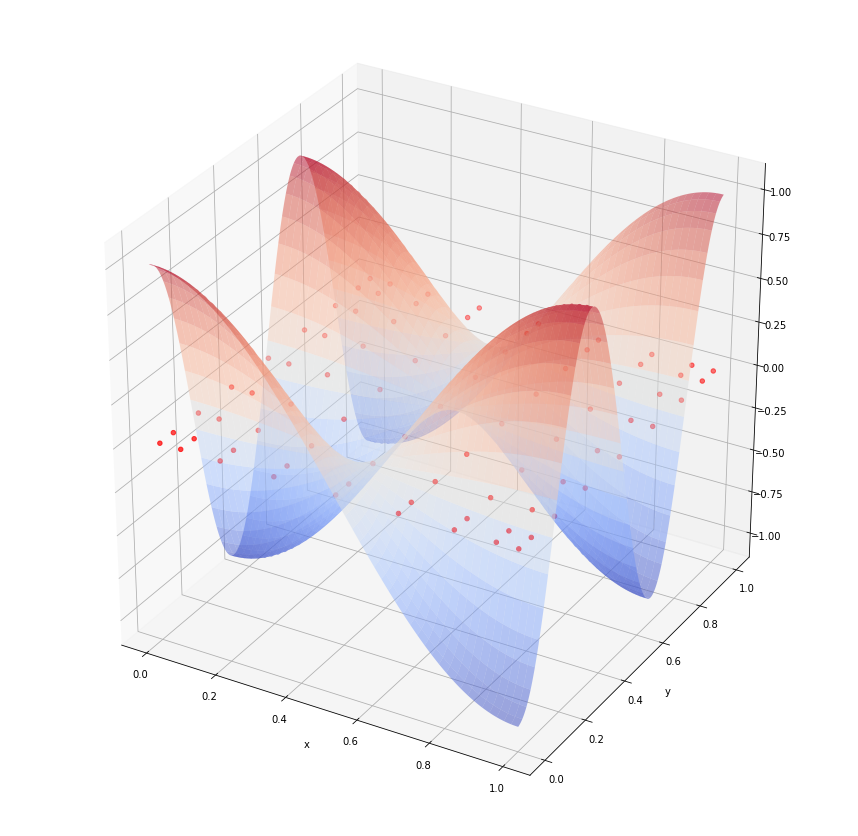

In [14]:
def differential_problem_solver(order, n_quad_m, n_quad_r, n_quad_e, 
                                plot_resolution, u_sym_func, apply_solution,
                                boundaries=(0, 1), plot_solution=True,
                                verbose=True):
    a, b = boundaries
    plot_linspace = np.linspace(a, b, plot_resolution)
    
    cheby_nodes = cheby_constr(order, a, b)
    basis_1d, Vs = lagrange_bases_cheby(cheby_nodes, order, plot_resolution, plot_linspace)
    
    Qm, Wm = gauss_legendre_quadr(n_quad_m, a, b)  
    Qr, Wr = gauss_legendre_quadr(n_quad_r, a, b)       
    Qe, We = gauss_legendre_quadr(n_quad_e, a, b)
    
    Vm, Vr, Ve = basis_evaluation_at_quad(order, basis_1d,
                                          n_quad_m, n_quad_r, n_quad_e,
                                          Qm, Qr, Qe)
    
    Dm, Dr, De = basis_derivatives_at_quad(order, basis_1d,
                                          n_quad_m, n_quad_r, n_quad_e,
                                          Qm, Qr, Qe)
    
    W2m, W2r, W2e = weights_2d(Wm, Wr, We)    
    V2s, V2m, V2r, V2e, VDm, DVm = basis_functions_2d(Vs, Vm, Vr, Ve, Dm)

    A = matrix_2d_builder(order, V2m, W2m, VDm, DVm)
    b_coeff = rhs_2d_builder(order, Qr, u_sym, V2r, W2r)

    u_approx, u_grid = solve_system(order, A, b_coeff, V2s)

    if plot_solution:
        print("Plotting.. (it may take a while)") if verbose else ""
        plot_3d_solution(plot_linspace, cheby_nodes, u_grid)

    u_precise = apply_solution(Qe, Qe)
    
    norm = calc_l2_norm(u_precise, u_approx, V2e, W2e)
    print("L2 norm:", norm) if verbose else ""
    return norm


# -------------------------------------------------------------------------------

order = 9
resolution = 256

x_sym, y_sym = sym.var('x'), sym.var('y')
u_sym = sym.cos(sym.pi * x_sym) * sym.cos(3 * sym.pi * y_sym)

differential_problem_solver(order, 10, 11, 12, resolution, u_sym, apply_solution)

In [20]:
def norms_calc(nq_m, nq_r, nq_e, degrees):
    norms = []

    for order_degree in degrees:
        print(order_degree, end=" - ")
        norms.append(differential_problem_solver(order_degree, nq_m, nq_r, nq_e, resolution,
                                                 u_sym, apply_solution,
                                                 plot_solution=False, verbose=False))

    return norms

3 - 4 - 5 - 6 - 7 - 8 - 9 - 10 - 11 - 12 - 13 - 14 - 15 - 16 - 17 - 18 - 19 - 20 - 21 - 22 - 23 - 24 - 25 - 26 - 

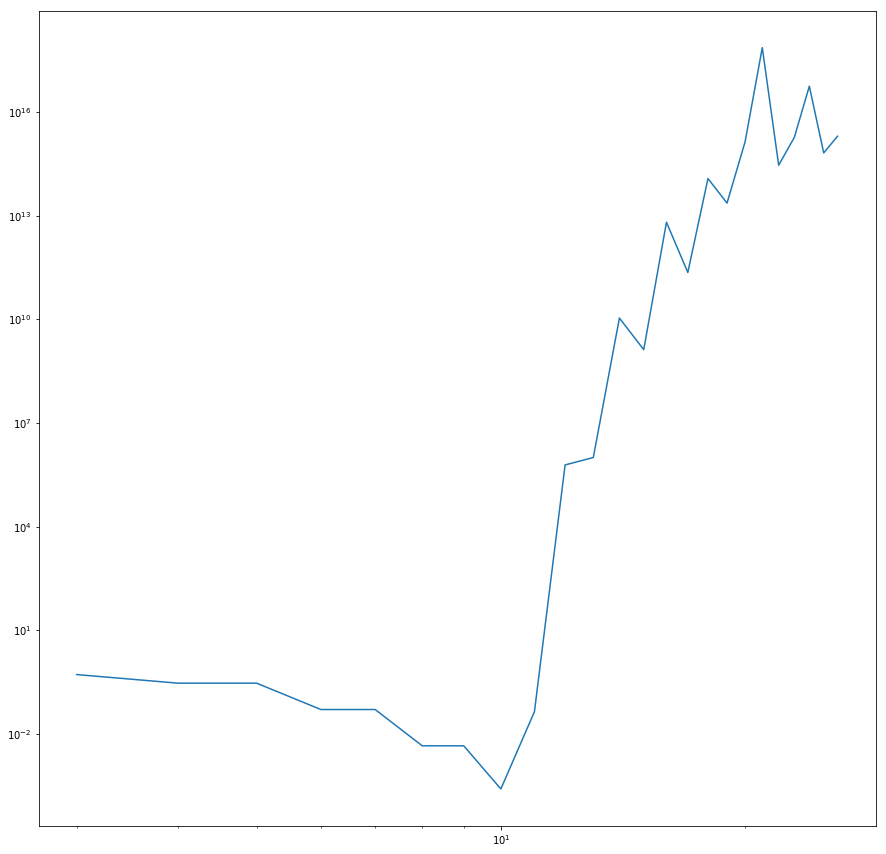

In [22]:
degrees = np.arange(3, 27)

norms = norms_calc(10, 11, 12, degrees)
_ = figure(figsize=[15, 15])
_ = loglog(degrees, norms)

3 - 4 - 5 - 6 - 7 - 8 - 9 - 10 - 11 - 12 - 13 - 14 - 15 - 16 - 17 - 18 - 19 - 20 - 21 - 22 - 23 - 24 - 25 - 26 - 

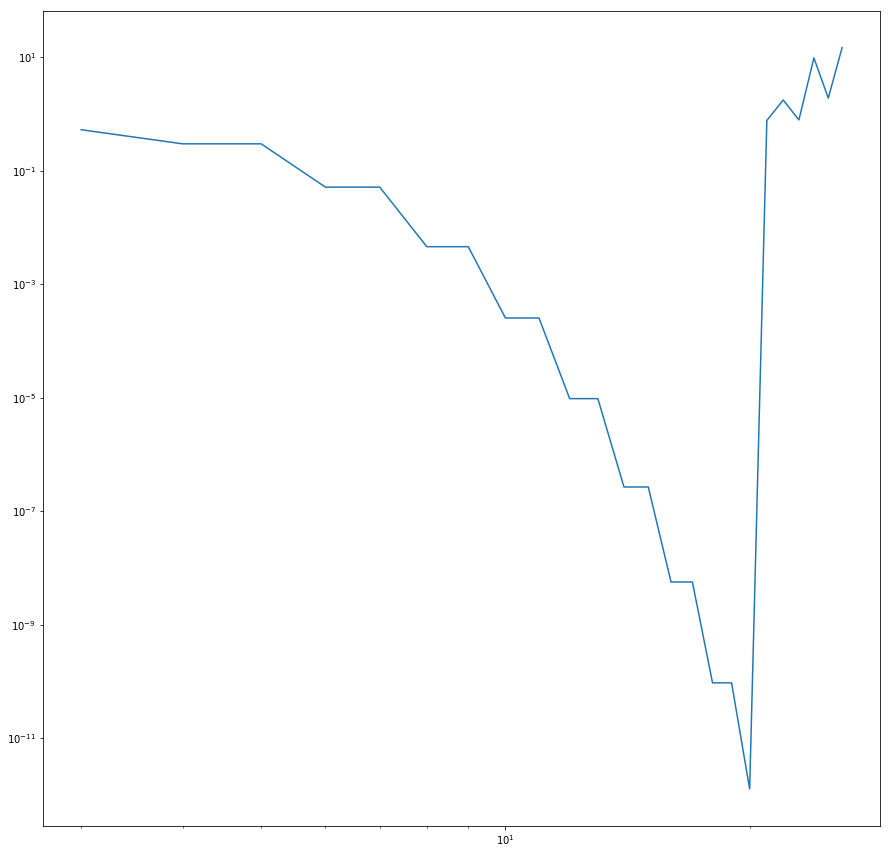

In [24]:
norms = norms_calc(20, 20, 22, degrees)

_ = figure(figsize=[15, 15])
_ = loglog(degrees, norms)

In [25]:
norms

[0.5232245469621256,
 0.29512580102286695,
 0.29512580102286695,
 0.05095578493177024,
 0.050955784931770116,
 0.004544175086438829,
 0.004544175086438762,
 0.00025164678999495184,
 0.00025164678999504823,
 9.55424402012306e-06,
 9.55424402008643e-06,
 2.649581355801808e-07,
 2.64958135280205e-07,
 5.61101399360621e-09,
 5.6110140550801364e-09,
 9.379203287460397e-11,
 9.379191736798216e-11,
 1.266529707952809e-12,
 0.7625795723355615,
 1.7457724085136965,
 0.7782859629993056,
 9.639188995479673,
 1.8874863626269112,
 14.605233279449747]

2.64958135280205e-07

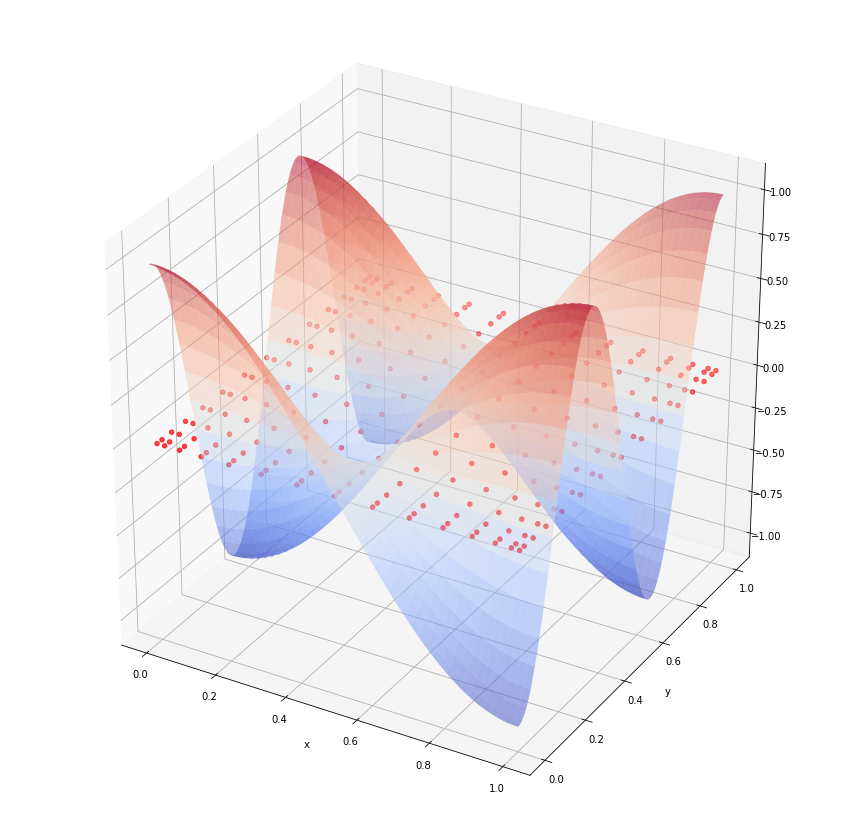

In [27]:
differential_problem_solver(15, 20, 20, 22, resolution,
                            u_sym, apply_solution,
                            verbose=False)

1.266529707952809e-12

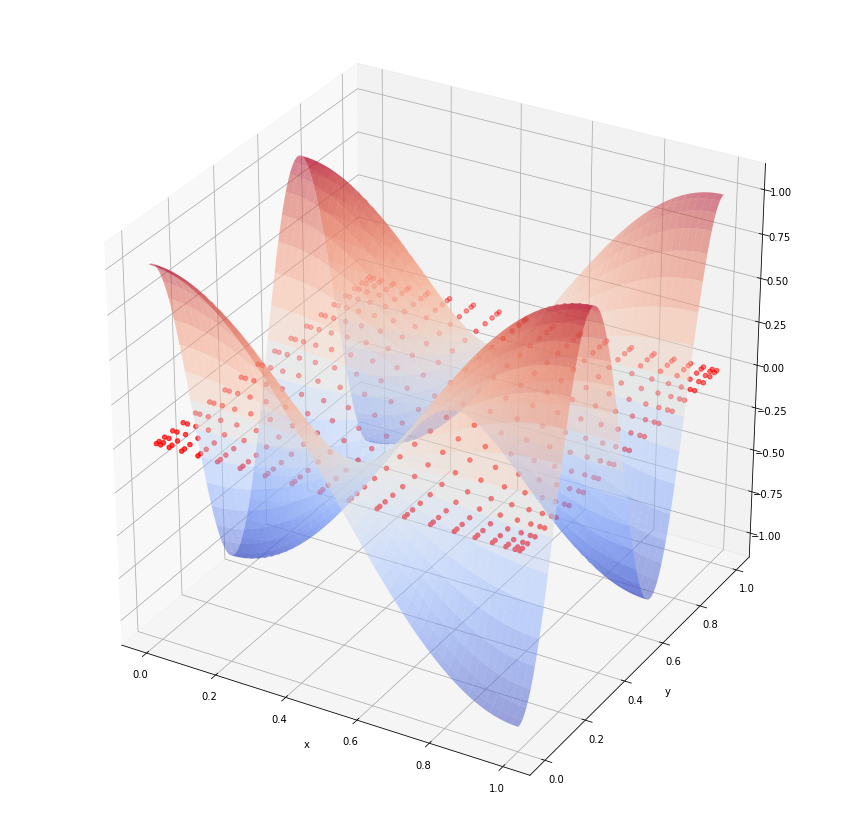

In [28]:
differential_problem_solver(20, 20, 20, 22, resolution,
                            u_sym, apply_solution,
                            verbose=False)

0.7625795723355615

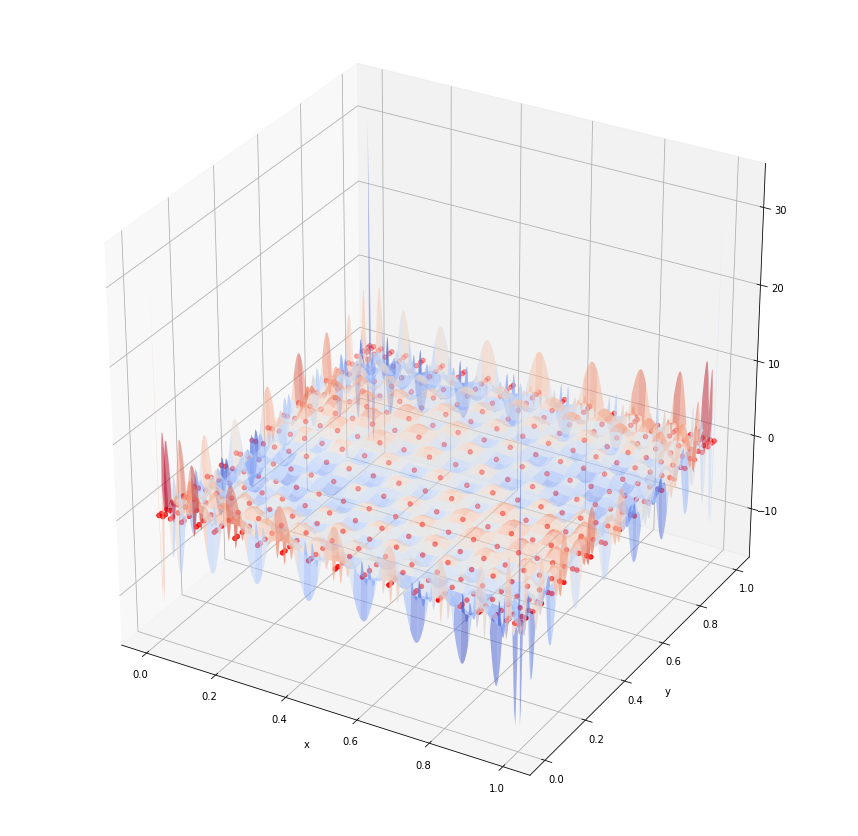

In [29]:
differential_problem_solver(21, 20, 20, 22, resolution,
                            u_sym, apply_solution,
                            verbose=False)

1.8874863626269112

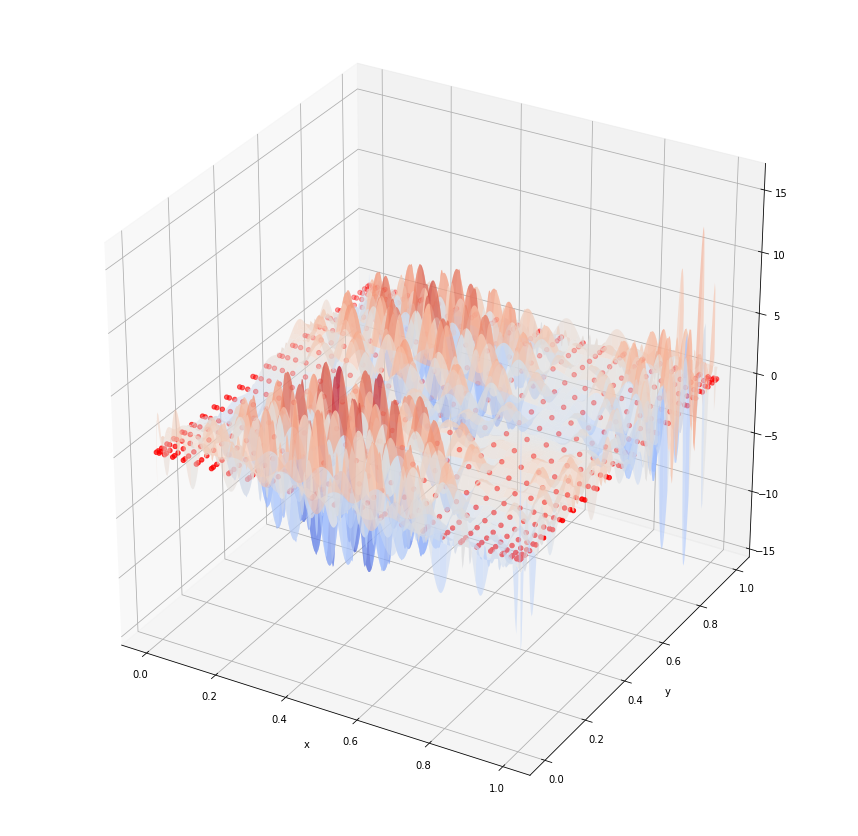

In [26]:
differential_problem_solver(25, 20, 20, 22, resolution,
                            u_sym, apply_solution,
                            verbose=False)

### 13 [OPTIONAL] Augment the function above

Make it take an optional argument that switches from a direct to an iterative solver (use CG, with a simple preconditioner of your choice).

Make a plot of cost it takes to run with iterative VS direct solvers. Is there a cross over point? For what degree?

### 14 [OPTIONAL] Matrix free

Using the iterative solver, implement a matrix-free approach where the computation of the matrices is substituted with a  function that returns the *matrix-vector* product. In doing so, you must take care of rewriting the assemble of the matrix as a sum of many *matrix-matrix* products exploiting all the possible tensor products. 

Compare and comment the compuational cost of 100 matrix-vector product when the matrix is assembled and when it is computed on-the-fly as a function of the degree of the finite element. Is there a cross-over point? Is matrix free always convenient?

To see an explanation of how matrix free works, take a look at this page: 

https://www.dealii.org/8.5.0/doxygen/deal.II/step_37.html